In [1]:
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [24]:
from torchvision import datasets, transforms
from torchmil.datasets import ToyDataset

# Load MNIST dataset
mnist = datasets.MNIST(
    "/tmp/", train=True, download=True, transform=transforms.ToTensor()
)

# Extract features and labels
data = mnist.data.view(-1, 28 * 28) / 255.0
labels = mnist.targets

# Define positive labels
obj_labels = [0, 1]

# Define bag size
bag_size = (7, 12)  # Randomly sample between 8 and 12 instances per bag

# Create MIL dataset
train_dataset = ToyDataset(
    data, labels, num_bags=10000, obj_labels=obj_labels, bag_size=bag_size, seed=0
)
test_dataset = ToyDataset(
    data, labels, num_bags=2000, obj_labels=obj_labels, bag_size=bag_size, seed=2
)

# Print one bag
print(train_dataset[0])

TensorDict(
    fields={
        X: Tensor(shape=torch.Size([11, 784]), device=cpu, dtype=torch.float32, is_shared=False),
        Y: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.int64, is_shared=False),
        y_inst: Tensor(shape=torch.Size([11]), device=cpu, dtype=torch.int64, is_shared=False)},
    batch_size=torch.Size([]),
    device=None,
    is_shared=False)


In [3]:
from torchmil.data import collate_fn

# Create dataloaders
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn
)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn
)

Masking is used to create a distinction between normal and padded images

TensorDict(
    fields={
        X: Tensor(shape=torch.Size([32, 11, 784]), device=cpu, dtype=torch.float32, is_shared=False),
        Y: Tensor(shape=torch.Size([32]), device=cpu, dtype=torch.int64, is_shared=False),
        mask: Tensor(shape=torch.Size([32, 11]), device=cpu, dtype=torch.uint8, is_shared=False),
        y_inst: Tensor(shape=torch.Size([32, 11]), device=cpu, dtype=torch.int64, is_shared=False)},
    batch_size=torch.Size([]),
    device=None,
    is_shared=False)


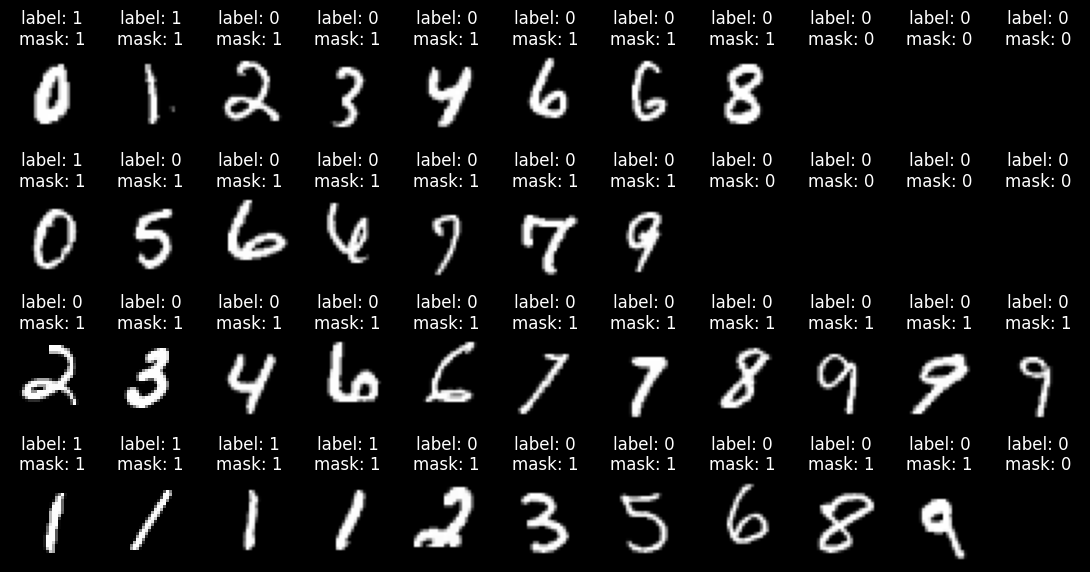

In [4]:
import matplotlib.pyplot as plt


def plot_batch(batch, max_bags=5):
    batch_size = min(len(batch["X"]), max_bags)
    bag_size = len(batch["X"][0])
    fig, axes = plt.subplots(batch_size, bag_size, figsize=(bag_size, 1.5 * batch_size))
    for i in range(batch_size):
        for j in range(bag_size):
            ax = axes[i, j]
            ax.imshow(batch["X"][i][j].view(28, 28), cmap="gray")
            title_str = f"label: {batch['y_inst'][i][j].item()}\nmask: {batch['mask'][i][j].item()}"
            ax.set_title(title_str)
            ax.axis("off")
    plt.tight_layout()
    plt.show()


batch = next(iter(train_dataloader))
print(batch)
plot_batch(batch, max_bags=4)

In [ ]:
from torchmil.nn import masked_softmax


class ABMIL(torch.nn.Module):
    def __init__(self, emb_dim, att_dim):
        super().__init__()

        # Feature extractor
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(28 * 28, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, emb_dim),
        )

        self.fc1 = torch.nn.Linear(emb_dim, att_dim)
        self.fc2 = torch.nn.Linear(att_dim, 1)

        self.classifier = torch.nn.Linear(emb_dim, 1)

    def forward(self, X, mask, return_att=False):
        X = self.mlp(X)  # (batch_size, bag_size, emb_dim)
        H = torch.tanh(self.fc1(X))  # (batch_size, bag_size, att_dim)

        # Getting attention scores
        att = torch.sigmoid(self.fc2(H))  # (batch_size, bag_size, 1)
        att_s = masked_softmax(att, mask)  # (batch_size, bag_size, 1)
        # att_s = torch.nn.functional.softmax(att, dim=1)
        X = torch.bmm(att_s.transpose(1, 2), X).squeeze(1)  # (batch_size, emb_dim)
        y = self.classifier(X).squeeze(1)  # (batch_size,)
        if return_att:
            return y, att_s
        else:
            return y


model = ABMIL(emb_dim=256, att_dim=128)
print(model)

ABMIL(
  (mlp): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
  )
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
  (classifier): Linear(in_features=256, out_features=1, bias=True)
)


In [13]:
example_input = torch.zeros((8, 3, 784))
mask = torch.ones((8, 3, 1))

In [15]:
model(example_input, mask)

tensor([0.0289, 0.0289, 0.0289, 0.0289, 0.0289, 0.0289, 0.0289, 0.0289],
       grad_fn=<SqueezeBackward1>)

In [17]:
model = ABMIL(emb_dim=256, att_dim=128)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
criterion = torch.nn.BCEWithLogitsLoss(reduction="mean")


def train(dataloader, epoch):
    model.train()

    sum_loss = 0.0
    sum_correct = 0.0
    for batch in dataloader:
        batch = batch.to(device)
        out = model(batch["X"], batch["mask"])
        loss = criterion(out, batch["Y"].float())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        sum_loss += loss.item()
        pred = (out > 0).float()
        sum_correct += (pred == batch["Y"]).sum().item()
        sum_loss += loss.item()

    print(
        f"[Epoch {epoch}] Train, train/loss: {sum_loss / len(dataloader)}, 'train/bag/acc': {sum_correct / len(dataloader.dataset)}"
    )


def val(dataloader, epoch):
    model.eval()

    sum_loss = 0.0
    sum_correct = 0.0
    for batch in dataloader:
        batch = batch.to(device)
        out = model(batch["X"], batch["mask"])
        loss = criterion(out, batch["Y"].float())

        sum_loss += loss.item()
        pred = (out > 0).float()
        sum_correct += (pred == batch["Y"]).sum().item()
        sum_loss += loss.item()

    print(
        f"[Epoch {epoch}] Validation, val/loss: {sum_loss / len(dataloader)}, 'val/bag/acc': {sum_correct / len(dataloader.dataset)}"
    )


model = model.to(device)
for epoch in range(20):
    train(train_dataloader, epoch + 1)
    val(test_dataloader, epoch + 1)

[Epoch 1] Train, train/loss: 0.38635448781779397, 'train/bag/acc': 0.916
[Epoch 1] Validation, val/loss: 0.14055075401824618, 'val/bag/acc': 0.9815
[Epoch 2] Train, train/loss: 0.1450674121800703, 'train/bag/acc': 0.9773
[Epoch 2] Validation, val/loss: 0.09828268445377784, 'val/bag/acc': 0.989
[Epoch 3] Train, train/loss: 0.11723379983295934, 'train/bag/acc': 0.9819
[Epoch 3] Validation, val/loss: 0.09519415155112271, 'val/bag/acc': 0.9875
[Epoch 4] Train, train/loss: 0.0971244325780997, 'train/bag/acc': 0.9861
[Epoch 4] Validation, val/loss: 0.0658902180425468, 'val/bag/acc': 0.989
[Epoch 5] Train, train/loss: 0.0875227111629761, 'train/bag/acc': 0.9878
[Epoch 5] Validation, val/loss: 0.0592667240472067, 'val/bag/acc': 0.9925
[Epoch 6] Train, train/loss: 0.07668219998362846, 'train/bag/acc': 0.9888
[Epoch 6] Validation, val/loss: 0.05838564042341969, 'val/bag/acc': 0.991
[Epoch 7] Train, train/loss: 0.06064714701751771, 'train/bag/acc': 0.9921
[Epoch 7] Validation, val/loss: 0.0644391

In [25]:
def accuracy(pred, y):
    return (pred == y).sum().item() / len(y)


def f1_score(pred, y):
    tp = ((pred == 1) & (y == 1)).sum().item()
    fp = ((pred == 1) & (y == 0)).sum().item()
    fn = ((pred == 0) & (y == 1)).sum().item()
    precision = tp / (tp + fp + 1e-6)
    recall = tp / (tp + fn + 1e-6)
    f1 = 2 * precision * recall / (precision + recall + 1e-6)
    return f1


def normalize(att, mask=None):
    if mask is None:
        mask = torch.ones_like(att)
    else:
        mask = mask.unsqueeze(-1)

    # exclude masked values from computing min and max
    att_tmp = att.clone()
    att_tmp[mask == 0] = float("inf")
    att_min = att_tmp.min(dim=1, keepdim=True).values
    att_tmp[mask == 0] = float("-inf")
    att_max = att_tmp.max(dim=1, keepdim=True).values
    att_min = att_min.expand_as(att)
    att_max = att_max.expand_as(att)

    # padded instances are set to min value, so that after normalization are set to 0
    att = torch.where(mask == 0, att_min, att)

    # normalize
    att_norm = (att - att_min) / (att_max - att_min + 1e-10)
    return att_norm

In [26]:
inst_pred_list = []
y_inst_list = []
Y_pred_list = []
Y_list = []

for batch in test_dataloader:
    batch = batch.to(device)

    # predict bag label and attention
    out, att = model(batch["X"], batch["mask"], return_att=True)
    Y_pred = (out > 0).float()

    # normalize attention
    att_norm = normalize(att, batch["mask"])

    # remove attention corresponding to padded instances
    att_norm = att_norm.view(-1)[batch["mask"].view(-1) == 1]
    inst_pred = (att_norm > 0.5).float()

    # remove labels corresponding to padded instances
    y_inst = batch["y_inst"].view(-1)[batch["mask"].view(-1) == 1]

    inst_pred_list.append(inst_pred)
    y_inst_list.append(y_inst)
    Y_pred_list.append(Y_pred)
    Y_list.append(batch["Y"])


inst_pred = torch.cat(inst_pred_list)
y_inst = torch.cat(y_inst_list)
Y_pred = torch.cat(Y_pred_list)
Y = torch.cat(Y_list)

print(f"test/bag/acc: {accuracy(Y_pred, Y)}")
print(f"test/bag/f1: {f1_score(Y_pred, Y)}")
print(f"test/inst/acc: {accuracy(inst_pred, y_inst)}")
print(f"test/inst/f1: {f1_score(inst_pred, y_inst)}")

test/bag/acc: 0.9925
test/bag/f1: 0.9924731568127686
test/inst/acc: 0.9876426909010307
test/inst/f1: 0.9478845197581358


# Attention maps

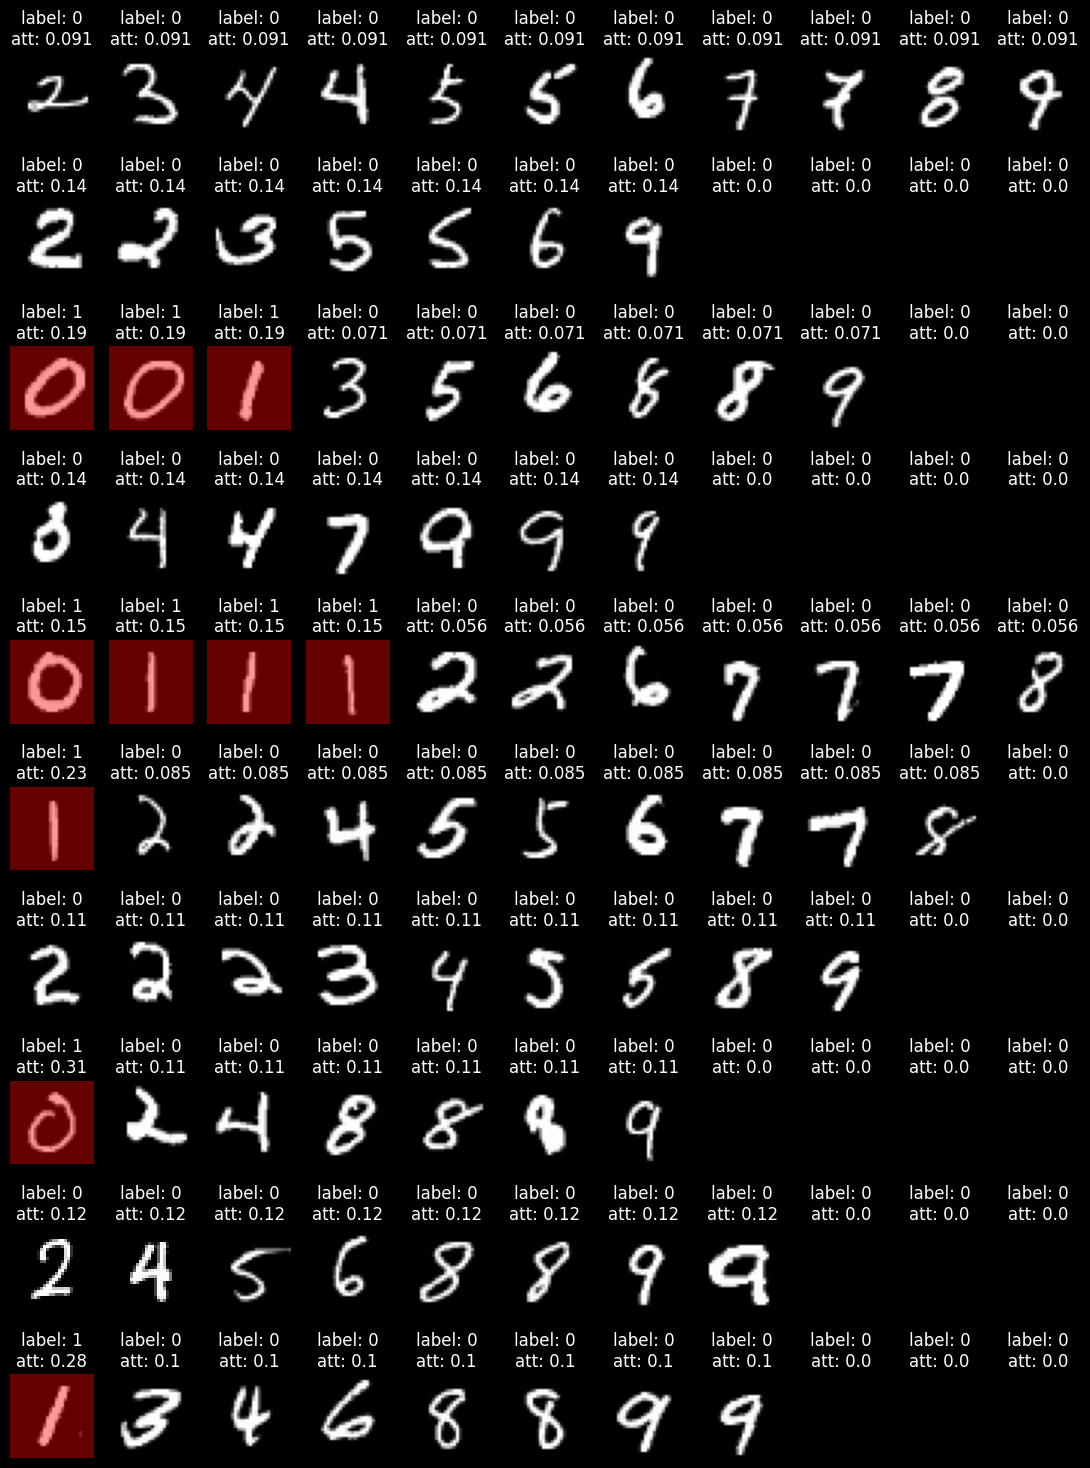

In [27]:
import numpy as np


def plot_batch_att(batch, att, max_bags=5):
    batch_size = min(len(batch["X"]), max_bags)
    bag_size = len(batch["X"][0])
    fig, axes = plt.subplots(batch_size, bag_size, figsize=(bag_size, 1.5 * batch_size))
    for i in range(batch_size):
        for j in range(bag_size):
            ax = axes[i, j]
            ax.imshow(batch["X"][i][j].view(28, 28), cmap="gray")
            # if the bag is positive, overlay red mask on the instance predicted as positive
            if batch["Y"][i] == 1:
                att_bag = normalize(
                    att[i].unsqueeze(0), batch["mask"][i].unsqueeze(0)
                ).squeeze(0)
                pred = (att_bag > 0.5).float()
                overlay_red = np.full(
                    (28, 28, 4), [1.0, 0.0, 0.0, 0.4 * pred[j].item()]
                )
                ax.imshow(overlay_red)
            title_str = (
                f"label: {batch['y_inst'][i][j].item()}\natt: {att[i][j].item():.2}"
            )
            ax.set_title(title_str)
            ax.axis("off")
    plt.tight_layout()
    plt.show()


batch = next(iter(test_dataloader))
batch = batch.to(device)
_, att = model(batch["X"], batch["mask"], return_att=True)
batch = batch.detach().cpu()
att = att.detach().cpu()
plot_batch_att(batch, att, max_bags=10)